# PHASE 2-2 improved

Loading CIFAR-10 dataset...
Preprocessing data...
Training set shape: (45000, 32, 32, 3)
Validation set shape: (5000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)

Training Model 1/4: {'optimizer': 'adam', 'lr': 0.001, 'batch_size': 64}
Epoch 1/50
704/704 [==============================] - ETA: 0s - loss: 3.0693 - accuracy: 0.2710
Epoch 1: val_accuracy improved from -inf to 0.39340, saving model to best_model_adam_lr0.001_bs64.keras
704/704 [==============================] - 115s 155ms/step - loss: 3.0693 - accuracy: 0.2710 - val_loss: 2.4786 - val_accuracy: 0.3934 - lr: 0.0010
Epoch 2/50
704/704 [==============================] - ETA: 0s - loss: 2.2703 - accuracy: 0.4270
Epoch 2: val_accuracy improved from 0.39340 to 0.47660, saving model to best_model_adam_lr0.001_bs64.keras
704/704 [==============================] - 101s 144ms/step - loss: 2.2703 - accuracy: 0.4270 - val_loss: 1.9956 - val_accuracy: 0.4766 - lr: 0.0010
Epoch 3/50
704/704 [==============================] - ETA: 0s -

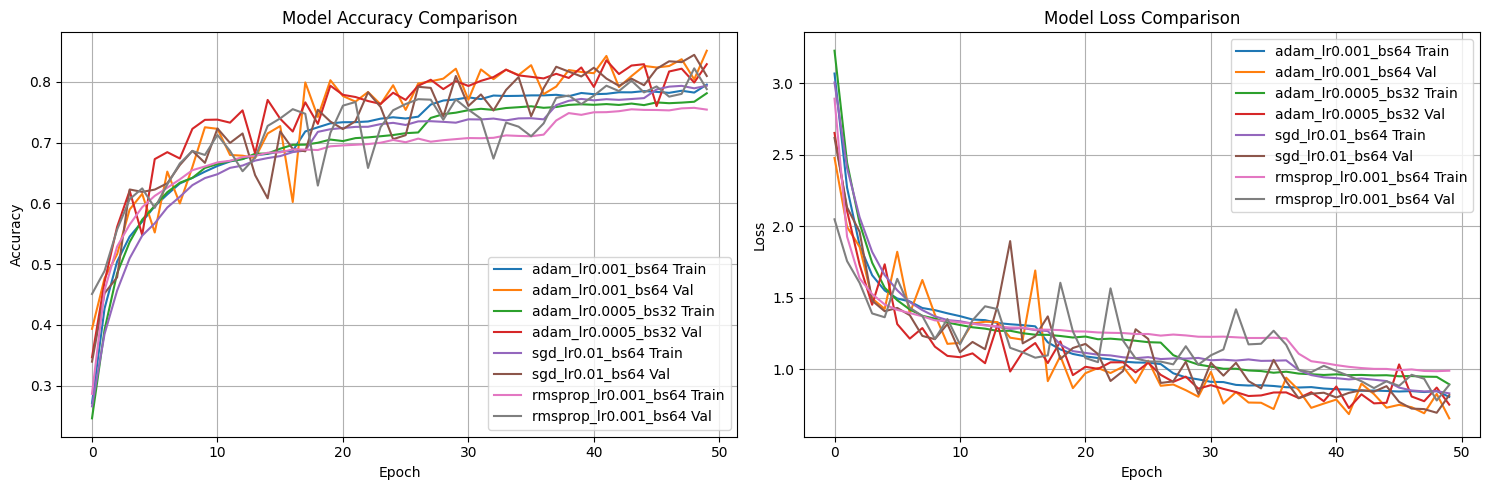


DETAILED EVALUATION OF BEST MODEL
313/313 [==============================] - 9s 26ms/step
Classification Report:
              precision    recall  f1-score   support

    airplane     0.8938    0.8080    0.8487      1000
  automobile     0.9405    0.9160    0.9281      1000
        bird     0.8930    0.7010    0.7854      1000
         cat     0.8304    0.6070    0.7013      1000
        deer     0.8063    0.8660    0.8351      1000
         dog     0.7979    0.7740    0.7858      1000
        frog     0.7261    0.9570    0.8257      1000
       horse     0.8658    0.8900    0.8777      1000
        ship     0.8649    0.9350    0.8986      1000
       truck     0.8388    0.9520    0.8918      1000

    accuracy                         0.8406     10000
   macro avg     0.8457    0.8406    0.8378     10000
weighted avg     0.8457    0.8406    0.8378     10000


Overall Metrics:
Precision: 0.8457
Recall: 0.8406
F1-Score: 0.8378


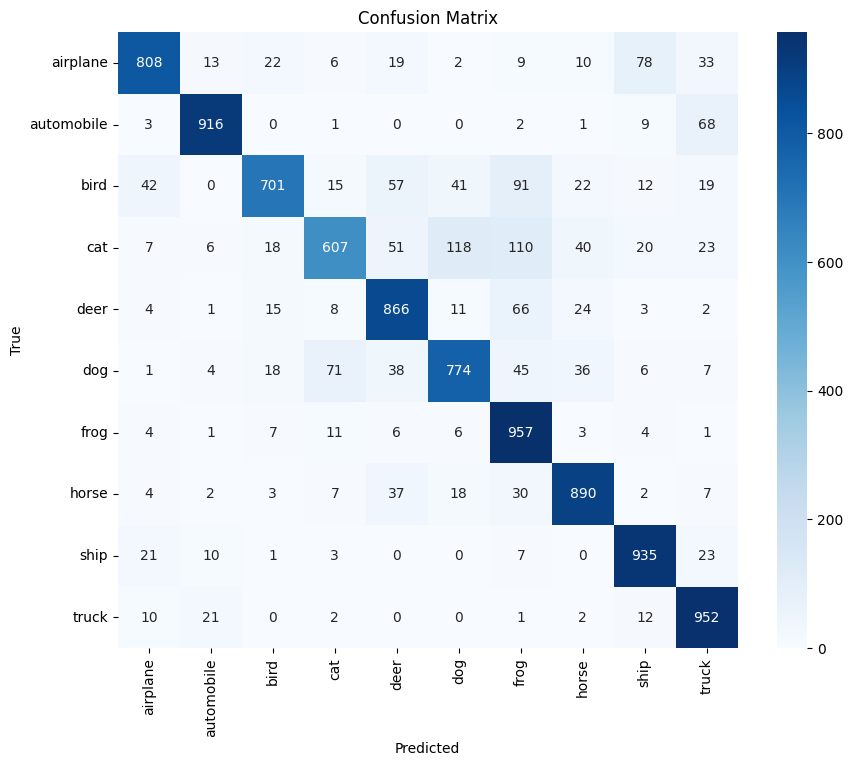

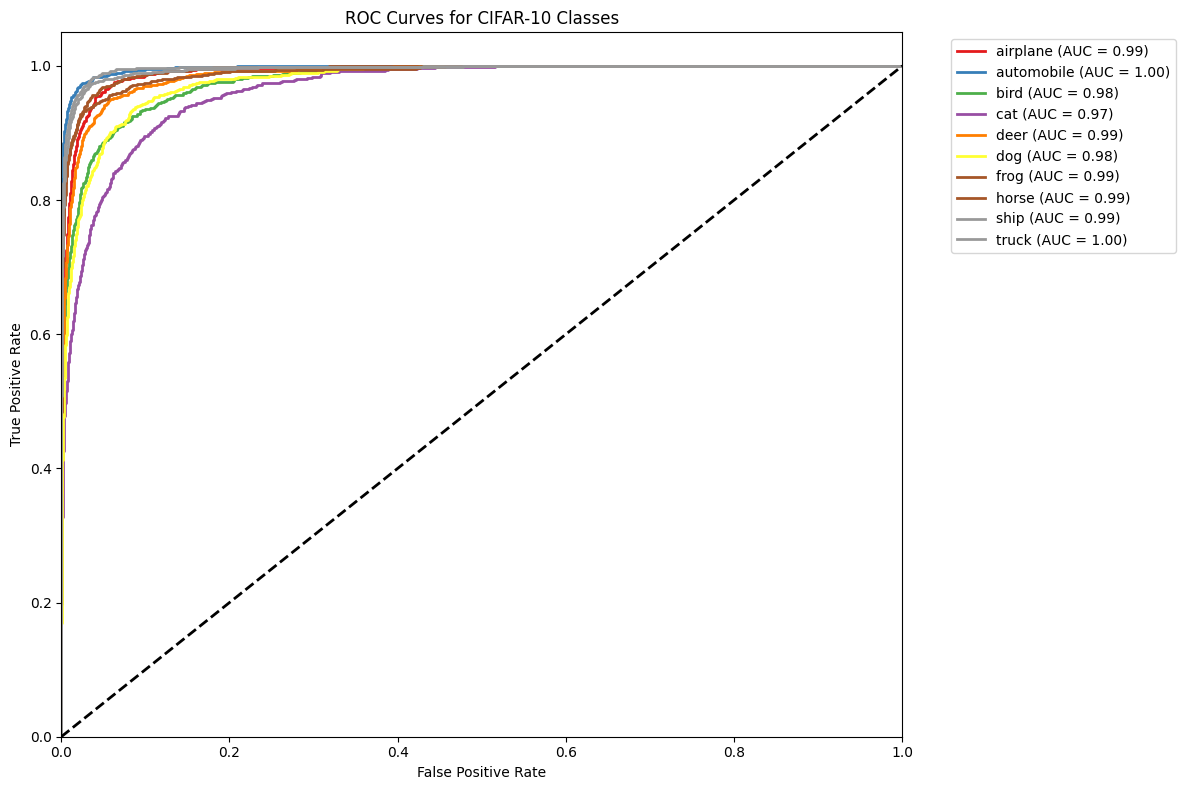

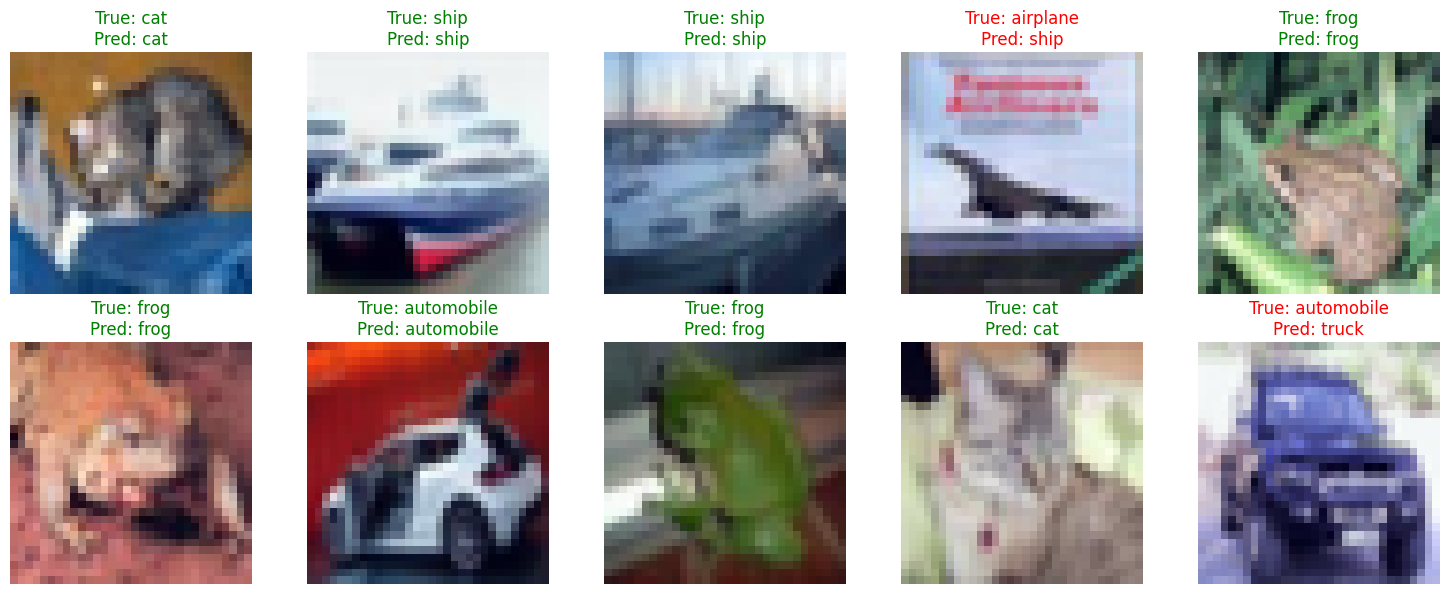


Best model saved as 'phase2_best_model.keras'

PHASE 2 COMPLETED SUCCESSFULLY!


In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
                                   BatchNormalization, Input, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2, l1_l2
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf


# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load CIFAR-10 from local directory
def load_batch(file_path):
    with open(file_path, 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
        data = dict[b'data']
        labels = dict[b'labels']
        data = data.reshape(len(data), 3, 32, 32).transpose(0, 2, 3, 1)
        return data, np.array(labels)

def load_cifar10_from_folder(folder_path):
    x_train = []
    y_train = []
    for i in range(1, 6):
        file_path = os.path.join(folder_path, f'data_batch_{i}')
        data, labels = load_batch(file_path)
        x_train.append(data)
        y_train.append(labels)
    x_train = np.concatenate(x_train)
    y_train = np.concatenate(y_train)
    
    x_test, y_test = load_batch(os.path.join(folder_path, 'test_batch'))
    return (x_train, y_train), (x_test, y_test)

# Data Preprocessing with enhanced normalization
def preprocess_data(x_train_full, x_test, y_train_full, y_test):
    # Normalize to [0,1] and then standardize
    x_train_full = x_train_full.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    
    # Calculate mean and std from training data only
    mean = np.mean(x_train_full, axis=(0, 1, 2))
    std = np.std(x_train_full, axis=(0, 1, 2))
    
    # Standardize
    x_train_full = (x_train_full - mean) / std
    x_test = (x_test - mean) / std
    
    # Split train/validation
    x_train, x_val = x_train_full[:45000], x_train_full[45000:]
    y_train, y_val = y_train_full[:45000], y_train_full[45000:]
    
    # One-hot encoding
    y_train = to_categorical(y_train, 10)
    y_val = to_categorical(y_val, 10)
    y_test_cat = to_categorical(y_test, 10)
    
    return x_train, x_val, x_test, y_train, y_val, y_test_cat

# Enhanced Data Augmentation with multiple techniques
def create_data_generators():
    # Training data augmentation (more aggressive)
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.15,
        shear_range=0.15,
        brightness_range=[0.8, 1.2],
        channel_shift_range=0.1,
        fill_mode='nearest'
    )
    
    # Validation data (no augmentation)
    val_datagen = ImageDataGenerator()
    
    return train_datagen, val_datagen

# Improved model architecture with better regularization
def create_improved_model():
    model = Sequential([
        Input(shape=(32, 32, 3)),
        
        # First block
        Conv2D(32, (3, 3), activation='relu', padding='same', 
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Second block
        Conv2D(64, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        MaxPooling2D(2, 2),
        Dropout(0.3),

        # Third block
        Conv2D(128, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        MaxPooling2D(2, 2),
        Dropout(0.4),

        # Global Average Pooling instead of Flatten (reduces overfitting)
        GlobalAveragePooling2D(),
        
        # Dense layers with regularization
        Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.001)),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.001)),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(10, activation='softmax')
    ])
    
    return model

# Hyperparameter tuning function
def train_with_hyperparameters(x_train, y_train, x_val, y_val, 
                              optimizer_name, learning_rate, batch_size):
    """Train model with specific hyperparameters"""
    
    # Create model
    model = create_improved_model()
    
    # Select optimizer
    optimizers = {
        'adam': Adam(learning_rate=learning_rate),
        'sgd': SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True),
        'rmsprop': RMSprop(learning_rate=learning_rate)
    }
    
    optimizer = optimizers[optimizer_name]
    
    # Compile model
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Create data generators
    train_datagen, val_datagen = create_data_generators()
    train_datagen.fit(x_train)
    
    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=15, 
                              restore_best_weights=True, verbose=1)
    model_name = f'best_model_{optimizer_name}_lr{learning_rate}_bs{batch_size}.keras'
    model_ckpt = ModelCheckpoint(model_name, save_best_only=True, 
                                monitor='val_accuracy', mode='max', verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, 
                                 min_lr=1e-7, verbose=1)
    
    
    # Train model
    history = model.fit(
        train_datagen.flow(x_train, y_train, batch_size=batch_size),
        validation_data=val_datagen.flow(x_val, y_val, batch_size=batch_size),
        epochs=50,
        callbacks=[early_stop, model_ckpt, reduce_lr],
        verbose=1
    )
    
    return history, model_name

# Visualization functions
def plot_training_history(histories, names):
    """Plot training histories for comparison"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    for history, name in zip(histories, names):
        ax1.plot(history.history['accuracy'], label=f'{name} Train')
        ax1.plot(history.history['val_accuracy'], label=f'{name} Val')
        
        ax2.plot(history.history['loss'], label=f'{name} Train')
        ax2.plot(history.history['val_loss'], label=f'{name} Val')
    
    ax1.set_title('Model Accuracy Comparison')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    ax2.set_title('Model Loss Comparison')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return cm

def plot_roc_curves(y_test, y_pred_proba, class_names):
    """Plot ROC curves for multiclass classification"""
    # Binarize the output
    y_test_bin = label_binarize(y_test, classes=range(10))
    
    plt.figure(figsize=(12, 8))
    colors = plt.cm.Set1(np.linspace(0, 1, 10))
    
    for i in range(10):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i], lw=2,
                label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for CIFAR-10 Classes')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def visualize_predictions(x_test, y_test, y_pred_labels, class_names, num_samples=10):
    """Visualize predictions with confidence"""
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    
    for i in range(num_samples):
        # Denormalize image for display
        img = x_test[i]
        img = (img - img.min()) / (img.max() - img.min())
        
        axes[i].imshow(img)
        true_label = class_names[y_test[i]]
        pred_label = class_names[y_pred_labels[i]]
        color = 'green' if y_test[i] == y_pred_labels[i] else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}', color=color)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    print("Loading CIFAR-10 dataset...")
    folder = "cifar-10-batches-py"
    (x_train_full, y_train_full), (x_test, y_test) = load_cifar10_from_folder(folder)
    
    print("Preprocessing data...")
    x_train, x_val, x_test, y_train, y_val, y_test_cat = preprocess_data(
        x_train_full, x_test, y_train_full, y_test)
    
    print(f"Training set shape: {x_train.shape}")
    print(f"Validation set shape: {x_val.shape}")
    print(f"Test set shape: {x_test.shape}")
    
    # Hyperparameter configurations to test
    hyperparameter_configs = [
        {'optimizer': 'adam', 'lr': 0.001, 'batch_size': 64},
        {'optimizer': 'adam', 'lr': 0.0005, 'batch_size': 32},
        {'optimizer': 'sgd', 'lr': 0.01, 'batch_size': 64},
        {'optimizer': 'rmsprop', 'lr': 0.001, 'batch_size': 64}
    ]
    
    histories = []
    model_names = []
    results = []
    
    # Train models with different hyperparameters
    for i, config in enumerate(hyperparameter_configs):
        print(f"\n{'='*50}")
        print(f"Training Model {i+1}/4: {config}")
        print(f"{'='*50}")
        
        history, model_name = train_with_hyperparameters(
            x_train, y_train, x_val, y_val,
            config['optimizer'], config['lr'], config['batch_size']
        )
        
        histories.append(history)
        model_names.append(model_name)
        
        # Evaluate model
        best_model = load_model(model_name)
        val_loss, val_acc = best_model.evaluate(x_val, y_val, verbose=0)
        test_loss, test_acc = best_model.evaluate(x_test, y_test_cat, verbose=0)
        
        results.append({
            'config': config,
            'val_acc': val_acc,
            'test_acc': test_acc,
            'model_name': model_name
        })
        
        print(f"Validation Accuracy: {val_acc:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")
    
    # Compare results
    print(f"\n{'='*60}")
    print("HYPERPARAMETER TUNING RESULTS")
    print(f"{'='*60}")
    
    for i, result in enumerate(results):
        config = result['config']
        print(f"Model {i+1}: {config['optimizer']} (lr={config['lr']}, bs={config['batch_size']})")
        print(f"  Validation Accuracy: {result['val_acc']:.4f}")
        print(f"  Test Accuracy: {result['test_acc']:.4f}")
        print()
    
    # Find best model
    best_idx = max(range(len(results)), key=lambda i: results[i]['val_acc'])
    best_model_name = results[best_idx]['model_name']
    best_config = results[best_idx]['config']
    
    print(f"Best Model: {best_config}")
    print(f"Best Validation Accuracy: {results[best_idx]['val_acc']:.4f}")
    print(f"Best Test Accuracy: {results[best_idx]['test_acc']:.4f}")
    
    # Plot training histories
    config_names = [f"{c['optimizer']}_lr{c['lr']}_bs{c['batch_size']}" 
                   for c in hyperparameter_configs]
    plot_training_history(histories, config_names)
    
    # Detailed evaluation of best model
    print(f"\n{'='*50}")
    print("DETAILED EVALUATION OF BEST MODEL")
    print(f"{'='*50}")
    
    best_model = load_model(best_model_name)
    
    # Get predictions
    y_pred_proba = best_model.predict(x_test)
    y_pred_labels = np.argmax(y_pred_proba, axis=1)
    
    # Class names
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']
    
    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred_labels, 
                              target_names=class_names, digits=4))
    
    # Calculate additional metrics
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    precision = precision_score(y_test, y_pred_labels, average='weighted')
    recall = recall_score(y_test, y_pred_labels, average='weighted')
    f1 = f1_score(y_test, y_pred_labels, average='weighted')
    
    print(f"\nOverall Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Plot confusion matrix
    cm = plot_confusion_matrix(y_test, y_pred_labels, class_names)
    
    # Plot ROC curves
    plot_roc_curves(y_test, y_pred_proba, class_names)
    
    # Visualize predictions
    visualize_predictions(x_test, y_test, y_pred_labels, class_names)
    
    # Save best model for next phases
    best_model.save('phase2_best_model.keras')
    print(f"\nBest model saved as 'phase2_best_model.keras'")
    
    print(f"\n{'='*50}")
    print("PHASE 2 COMPLETED SUCCESSFULLY!")
    print(f"{'='*50}")